# Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

import xgboost as xgb

# Data

In [2]:
# source https://huggingface.co/datasets/aneesarom/Food-Delivery

df_test_raw = pd.read_parquet('https://huggingface.co/datasets/aneesarom/Food-Delivery/resolve/main/data/test-00000-of-00001.parquet?download=true')
df_train_raw = pd.read_parquet('https://huggingface.co/datasets/aneesarom/Food-Delivery/resolve/main/data/train-00000-of-00001.parquet?download=true')

df = pd.concat([df_train_raw, df_test_raw], ignore_index=True)

In [3]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0x6bbb,INDORES02DEL01,23.0,4.5,22.651847,75.881991,22.721847,75.951991,18-03-2022,22:10,22:25,Stormy,Low,1,Buffet,motorcycle,1.0,No,Metropolitian,17
1,0x190a,MYSRES20DEL01,39.0,4.3,12.337978,76.616792,12.377978,76.656792,17-03-2022,15:10,15:20,Cloudy,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,33
2,0x120c,MYSRES07DEL02,37.0,4.8,12.325461,76.632278,12.375461,76.682278,03-03-2022,23:55,24:10:00,Windy,Low,2,Meal,scooter,0.0,No,None,20
3,0x6016,SURRES12DEL03,30.0,4.8,21.183434,72.814492,21.213434,72.844492,05-03-2022,17:35,17:40,Sandstorms,Medium,0,Snack,motorcycle,0.0,No,Metropolitian,27
4,0x9ca0,VADRES13DEL02,29.0,4.6,22.310237,73.158921,22.360237,73.208921,11-03-2022,21:30,21:45,Cloudy,Jam,2,Buffet,scooter,0.0,No,Metropolitian,26


# Data cleaning

In [4]:
# Clean the column names

df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('(','').str.replace(')','').str.replace('time_orderd', 'time_ordered')

In [5]:
# Clean the strings

columns = list(df.columns[df.dtypes == 'object'])

for col in columns:
    df[col] = df[col].str.lower().str.replace(' ','_')

In [6]:
df.isna().sum()

id                                0
delivery_person_id                0
delivery_person_age            1854
delivery_person_ratings        1908
restaurant_latitude               0
restaurant_longitude              0
delivery_location_latitude        0
delivery_location_longitude       0
order_date                        0
time_ordered                   1731
time_order_picked                 0
weather_conditions              616
road_traffic_density            601
vehicle_condition                 0
type_of_order                     0
type_of_vehicle                   0
multiple_deliveries             993
festival                        228
city                           1200
time_taken_min                    0
dtype: int64

In [7]:
# Null values

df = df[df['multiple_deliveries'].notna()]

df['time_ordered'] = df['time_ordered'].fillna('unknown')
df['weather_conditions'] = df['weather_conditions'].fillna('unknown')
df['road_traffic_density'] = df['road_traffic_density'].fillna('unknown')
df['festival'] = df['festival'].fillna('unknown')
df['city'] = df['city'].fillna('unknown')

<Axes: xlabel='time_taken_min', ylabel='Count'>

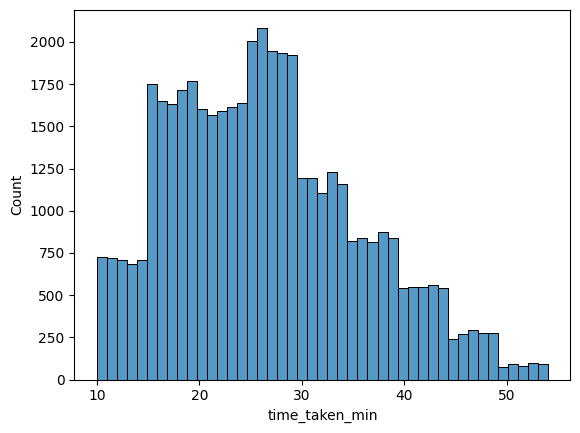

In [8]:
# Target value distribution

sns.histplot(df['time_taken_min'], bins=45)

In [9]:
# There is a feature called vehicle_conditions that is represented by IDs without actual values  
# And the data source doesn't have this information  
# Let's pretend we have these values

vehicle_conditions = {
    1:'ok', 
    2:'small_damage',
    3:'damage',
    0:'unknown'
}

df.vehicle_condition = df.vehicle_condition.map(vehicle_conditions)

# Calculate features that are important for delivery time prediction

## Distance

In [10]:
#!pip install haversine

In [11]:
from haversine import haversine, Unit

def calculate_distance(row):
    restaurant_coords = (row['restaurant_latitude'], row['restaurant_longitude'])
    delivery_coords = (row['delivery_location_latitude'], row['delivery_location_longitude'])
    return haversine(restaurant_coords, delivery_coords, unit=Unit.KILOMETERS)

df['distance_km'] = df.apply(calculate_distance, axis=1)


## Order day and time

In [12]:
df['order_timestamp'] = pd.to_datetime(
    df['order_date'] + ' ' + df['time_ordered'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)


df['picked_timestamp'] = pd.to_datetime(
    df['order_date'] + ' ' + df['time_order_picked'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

mask_24h = df['picked_timestamp'].isna() & df['time_order_picked'].str.startswith('24:', na=False)


if mask_24h.any():

    next_day_date = pd.to_datetime(df.loc[mask_24h, 'order_date'], format='%d-%m-%Y') + pd.Timedelta(days=1)
    
    corrected_time = df.loc[mask_24h, 'time_order_picked'].str.replace('24:', '00:', 1)

    df.loc[mask_24h, 'picked_timestamp'] = pd.to_datetime(
        next_day_date.dt.strftime('%Y-%m-%d') + ' ' + corrected_time
    )


df['order_hour'] = df['order_timestamp'].dt.hour
df['order_day_of_week'] = df['order_timestamp'].dt.dayofweek
df['preparation_time_mins'] = (df['picked_timestamp'] - df['order_timestamp']).dt.total_seconds() / 60


In [13]:
df = df[df['preparation_time_mins'].notna()]

df.isna().sum()


id                               0
delivery_person_id               0
delivery_person_age            168
delivery_person_ratings        208
restaurant_latitude              0
restaurant_longitude             0
delivery_location_latitude       0
delivery_location_longitude      0
order_date                       0
time_ordered                     0
time_order_picked                0
weather_conditions               0
road_traffic_density             0
vehicle_condition                0
type_of_order                    0
type_of_vehicle                  0
multiple_deliveries              0
festival                         0
city                             0
time_taken_min                   0
distance_km                      0
order_timestamp                  0
picked_timestamp                 0
order_hour                       0
order_day_of_week                0
preparation_time_mins            0
dtype: int64

# Prepare data for training, validation and testing

In [14]:
# Leaving only features that important

df.columns

Index(['id', 'delivery_person_id', 'delivery_person_age',
       'delivery_person_ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_location_latitude',
       'delivery_location_longitude', 'order_date', 'time_ordered',
       'time_order_picked', 'weather_conditions', 'road_traffic_density',
       'vehicle_condition', 'type_of_order', 'type_of_vehicle',
       'multiple_deliveries', 'festival', 'city', 'time_taken_min',
       'distance_km', 'order_timestamp', 'picked_timestamp', 'order_hour',
       'order_day_of_week', 'preparation_time_mins'],
      dtype='object')

In [15]:
df.dtypes

id                                     object
delivery_person_id                     object
delivery_person_age                   float64
delivery_person_ratings               float64
restaurant_latitude                   float64
restaurant_longitude                  float64
delivery_location_latitude            float64
delivery_location_longitude           float64
order_date                             object
time_ordered                           object
time_order_picked                      object
weather_conditions                     object
road_traffic_density                   object
vehicle_condition                      object
type_of_order                          object
type_of_vehicle                        object
multiple_deliveries                   float64
festival                               object
city                                   object
time_taken_min                          int64
distance_km                           float64
order_timestamp                dat

In [16]:
df_prepared = df[['delivery_person_age', 'delivery_person_ratings', 'weather_conditions', 'road_traffic_density', 'vehicle_condition', 
    'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival', 'city', 'time_taken_min',
                 'distance_km', 'order_hour', 'order_day_of_week', 'preparation_time_mins']]

df_prepared.head()

,delivery_person_age,delivery_person_ratings,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min,distance_km,order_hour,order_day_of_week,preparation_time_mins
0,23.0,4.5,stormy,low,ok,buffet,motorcycle,1.0,no,metropolitian,17,10.590463,22.0,4.0,15.0
1,39.0,4.3,cloudy,medium,unknown,buffet,motorcycle,1.0,no,metropolitian,33,6.217698,15.0,3.0,10.0
2,37.0,4.8,windy,low,small_damage,meal,scooter,0.0,no,unknown,20,7.772231,23.0,3.0,15.0
3,30.0,4.8,sandstorms,medium,unknown,snack,motorcycle,0.0,no,metropolitian,27,4.560790,17.0,5.0,5.0
4,29.0,4.6,cloudy,jam,small_damage,buffet,scooter,0.0,no,metropolitian,26,7.573481,21.0,4.0,15.0


In [17]:
df_full_train, df_test = train_test_split(df_prepared, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [18]:
df_full_train = df_full_train.reset_index(drop=True)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
y_full_train = df_full_train.time_taken_min.values

y_train = df_train.time_taken_min.values
y_val = df_val.time_taken_min.values
y_test = df_test.time_taken_min.values

In [20]:
del df_full_train['time_taken_min']

del df_train['time_taken_min']
del df_val['time_taken_min']
del df_test['time_taken_min']

In [21]:
# Deal with null values in delivery_person_age and delivery_person_ratings columns 

# df_full_train

median_delivery_person_age = df_full_train['delivery_person_age'].median()
median_delivery_person_ratings = df_full_train['delivery_person_ratings'].median()

df_full_train['delivery_person_age'] = df_full_train['delivery_person_age'].fillna(median_delivery_person_age)
df_full_train['delivery_person_ratings'] = df_full_train['delivery_person_ratings'].fillna(median_delivery_person_ratings)

# df_train

median_delivery_person_age = df_train['delivery_person_age'].median()
median_delivery_person_ratings = df_train['delivery_person_ratings'].median()

df_train['delivery_person_age'] = df_train['delivery_person_age'].fillna(median_delivery_person_age)
df_train['delivery_person_ratings'] = df_train['delivery_person_ratings'].fillna(median_delivery_person_ratings)

# df_val

median_delivery_person_age = df_val['delivery_person_age'].median()
median_delivery_person_ratings = df_val['delivery_person_ratings'].median()

df_val['delivery_person_age'] = df_val['delivery_person_age'].fillna(median_delivery_person_age)
df_val['delivery_person_ratings'] = df_val['delivery_person_ratings'].fillna(median_delivery_person_ratings)

# df_test

median_delivery_person_age = df_test['delivery_person_age'].median()
median_delivery_person_ratings = df_test['delivery_person_ratings'].median()

df_test['delivery_person_age'] = df_test['delivery_person_age'].fillna(median_delivery_person_age)
df_test['delivery_person_ratings'] = df_test['delivery_person_ratings'].fillna(median_delivery_person_ratings)


# Metric to evaluate model

In [22]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

# Train a DecisionTreeRegressor model

In [23]:
train_dicts = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

In [24]:
dv.get_feature_names_out()

array(['city=metropolitian', 'city=semi-urban', 'city=unknown',
       'city=urban', 'delivery_person_age', 'delivery_person_ratings',
       'distance_km', 'festival=no', 'festival=unknown', 'festival=yes',
       'multiple_deliveries', 'order_day_of_week', 'order_hour',
       'preparation_time_mins', 'road_traffic_density=high',
       'road_traffic_density=jam', 'road_traffic_density=low',
       'road_traffic_density=medium', 'type_of_order=buffet',
       'type_of_order=drinks', 'type_of_order=meal',
       'type_of_order=snack', 'type_of_vehicle=electric_scooter',
       'type_of_vehicle=motorcycle', 'type_of_vehicle=scooter',
       'vehicle_condition=ok', 'vehicle_condition=small_damage',
       'vehicle_condition=unknown', 'weather_conditions=cloudy',
       'weather_conditions=fog', 'weather_conditions=sandstorms',
       'weather_conditions=stormy', 'weather_conditions=sunny',
       'weather_conditions=windy'], dtype=object)

In [25]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [26]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = dt.predict(X_val)

In [27]:
rmse(y_val, y_pred)

5.297968819191919

In [28]:
print(export_text(dt,feature_names=dv.get_feature_names_out()))

|--- delivery_person_ratings <= 4.45
|   |--- road_traffic_density=low <= 0.50
|   |   |--- festival=no <= 0.50
|   |   |   |--- vehicle_condition=unknown <= 0.50
|   |   |   |   |--- type_of_order=buffet <= 0.50
|   |   |   |   |   |--- distance_km <= 11.54
|   |   |   |   |   |   |--- delivery_person_ratings <= 4.35
|   |   |   |   |   |   |   |--- delivery_person_ratings <= 4.25
|   |   |   |   |   |   |   |   |--- distance_km <= 10.81
|   |   |   |   |   |   |   |   |   |--- order_day_of_week <= 1.00
|   |   |   |   |   |   |   |   |   |   |--- value: [40.00]
|   |   |   |   |   |   |   |   |   |--- order_day_of_week >  1.00
|   |   |   |   |   |   |   |   |   |   |--- delivery_person_age <= 37.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- delivery_person_age >  37.00
|   |   |   |   |   |   |   |   |   |   |   |--- value: [42.00]
|   |   |   |   |   |   |   |   |--- distance_km >  10.81
|   |   |   |   

<Axes: ylabel='Count'>

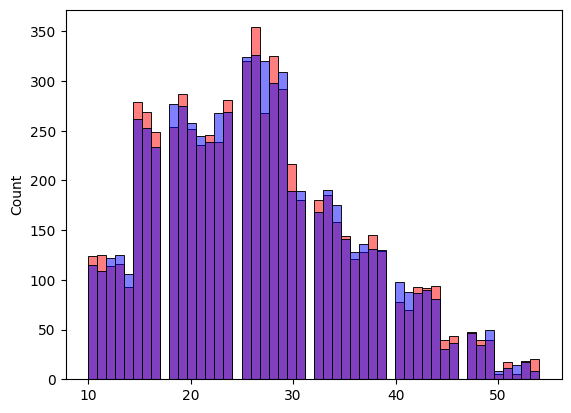

In [29]:
sns.histplot(y_pred, bins=50, alpha=0.5, color='red')
sns.histplot(y_val, bins=50, alpha=0.5, color='blue')

In [30]:
for d in [1,2,3,4,5,6,10,15,20,None]:
    
    dt = DecisionTreeRegressor(max_depth=d, random_state=1)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_val)
    score = rmse(y_val, y_pred)

    print('%4s -> %.3f' % (d, score))

   1 -> 8.321
   2 -> 7.535
   3 -> 6.963
   4 -> 6.462
   5 -> 5.930
   6 -> 5.462
  10 -> 4.115
  15 -> 4.544
  20 -> 5.164
None -> 5.309


In [31]:
scores = []

for d in  [6, 10, 15]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:

        dt = DecisionTreeRegressor(max_depth=d, min_samples_leaf=s, random_state=1)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict(X_val)
        score = rmse(y_val, y_pred)

        scores.append((d,s,score))

In [32]:
df_scores = pd.DataFrame(scores, columns=('max_depth', 'min_samples_leaf', 'rmse'))
df_scores.sort_values('rmse', ascending=True).head()

,max_depth,min_samples_leaf,rmse
14,10,20,4.082495
13,10,15,4.094854
12,10,10,4.102259
11,10,5,4.106065
23,15,20,4.109704


In [33]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', 
                                  columns='max_depth', 
                                  values='rmse')

df_scores_pivot

max_depth,6,10,15
min_samples_leaf,,,
1,5.461857,4.114855,4.544322
2,5.461604,4.118535,4.460787
5,5.462329,4.106065,4.335527
10,5.464214,4.102259,4.202764
15,5.462866,4.094854,4.163095
20,5.461260,4.082495,4.109704
100,5.461377,4.380090,4.390508
200,5.496694,4.836569,4.839190
500,5.651628,5.503435,5.503435


In [34]:
df_scores_pivot.round(3)

max_depth,6,10,15
min_samples_leaf,,,
1,5.462,4.115,4.544
2,5.462,4.119,4.461
5,5.462,4.106,4.336
10,5.464,4.102,4.203
15,5.463,4.095,4.163
20,5.461,4.082,4.110
100,5.461,4.380,4.391
200,5.497,4.837,4.839
500,5.652,5.503,5.503


<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

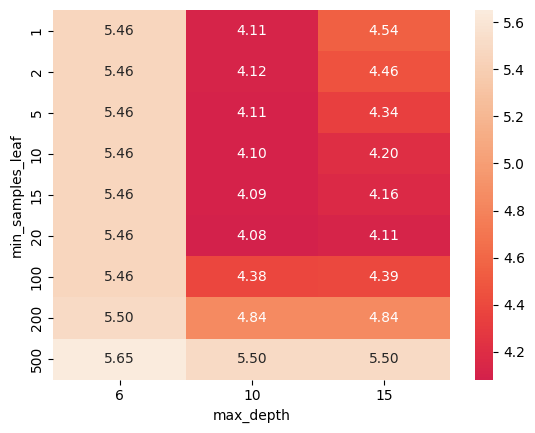

In [35]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.2f', cmap='rocket', center=4.0)

In [36]:
# DecisionTreeRegressor Params

max_depth = 10
min_samples_leaf = 20

In [37]:
dt = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=20, random_state=1)

In [38]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = dt.predict(X_val)

In [39]:
rmse(y_val, y_pred)

4.0824951380985715

# Train a RandomForestRegressor model

In [40]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [41]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = rf.predict(X_val)

In [42]:
rmse(y_val, y_pred)

4.058256232906668

In [43]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = rmse(y_val, y_pred)

    scores.append((n, score))

In [44]:
df_scores = pd.DataFrame(scores, columns=('n_estimators', 'rmse'))
df_scores.sort_values('rmse', ascending=True).head(n=10)

,n_estimators,rmse
18,190,3.902611
19,200,3.903661
17,180,3.904018
16,170,3.904919
15,160,3.907640
14,150,3.909371
10,110,3.910038
12,130,3.910086
13,140,3.910758
11,120,3.911379


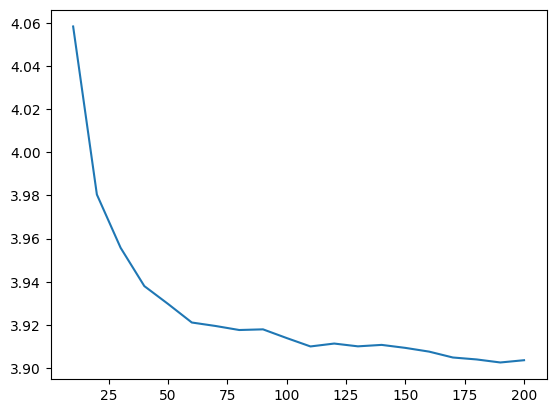

In [45]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [46]:
# RandomForestRegressor Params

n_estimators=190

In [47]:
scores = []

for d in [5, 10, 15, 20]:

    for n in range(10, 201, 10):
        
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        score = rmse(y_val, y_pred)
    
        scores.append((n, d, score))

In [48]:
df_scores = pd.DataFrame(scores, columns=('n_estimators', 'max_depth', 'rmse'))
df_scores.sort_values('rmse', ascending=True).head()

,n_estimators,max_depth,rmse
58,190,15,3.875827
59,200,15,3.876423
57,180,15,3.876558
56,170,15,3.876982
54,150,15,3.878783


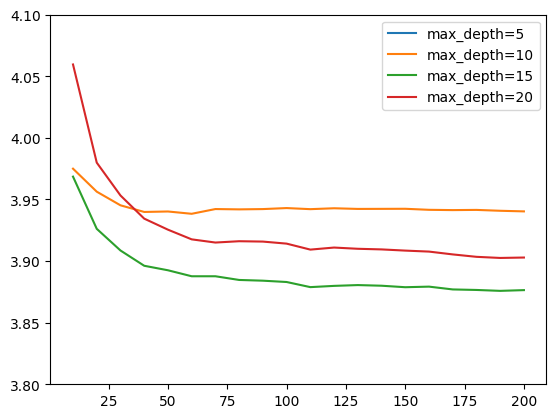

In [49]:
for d in [5, 10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label = 'max_depth=%d' % d)

    plt.ylim(3.8, 4.1)
    plt.legend()
    

In [50]:
# RandomForestRegressor Params

n_estimators=190
max_depth=15

In [51]:
scores = []

for s in [1, 3, 5, 10, 50]:

    for n in range(10, 201, 10):
            
            rf = RandomForestRegressor(n_estimators=n, 
                                        max_depth=max_depth, 
                                        min_samples_leaf=s,
                                        random_state=1, n_jobs=-1)
            rf.fit(X_train, y_train)
            
            y_pred = rf.predict(X_val)
            score = rmse(y_val, y_pred)
        
            scores.append((n, s, score))

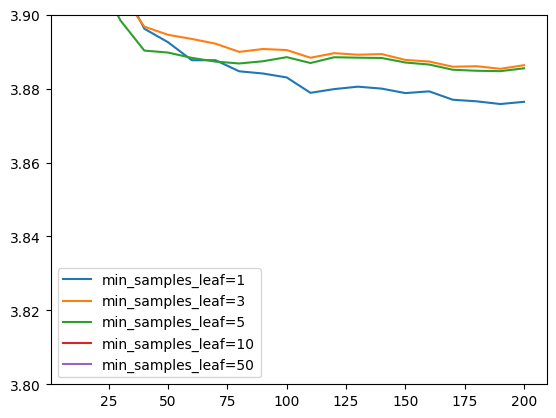

In [52]:
df_scores = pd.DataFrame(scores, columns=('n_estimators', 'min_samples_leaf', 'rmse'))

for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label = 'min_samples_leaf=%s' % s)

    plt.ylim(3.8, 3.9)
    plt.legend()

In [53]:
# RandomForestRegressor Params

n_estimators=190
max_depth=15
min_samples_leaf=1

In [54]:
rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=190, random_state=1)

In [55]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = rf.predict(X_val)

In [56]:
rmse(y_val, y_pred)

3.875827256974107

# Train a XGBoost model

In [57]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [58]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [59]:
y_pred = model.predict(dval)

In [60]:
rmse(y_val, y_pred)

5.673502431646247

In [61]:
watchlist = [(dtrain, 'train'),(dval, 'val')]

In [62]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [63]:
# tuning eta

scores = {}

In [64]:
%%capture output

xgb_params = {
    'eta': 1.0, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

# ['eta=0.1', 'eta=0.3', 'eta=1.0', 'eta=0.2', 'eta=0.01']

In [65]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [66]:
scores.keys()

dict_keys(['eta=1.0'])

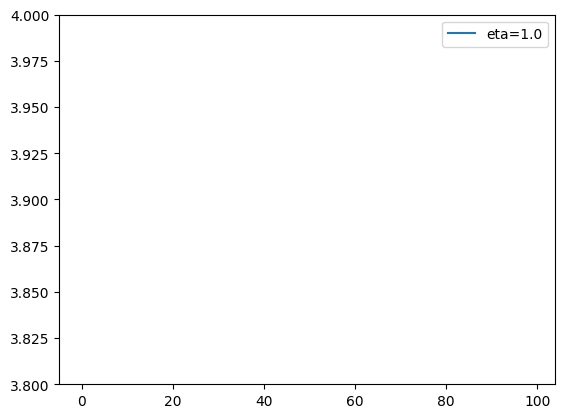

In [67]:
for key, df_score in scores.items():
    
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key)

plt.ylim(3.8, 4.0)
plt.legend()

In [68]:
# XGBoost Params

eta=0.1

In [69]:
# tuning max_depth

scores = {}

In [70]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)



key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

# ['max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=10']

In [71]:
scores.keys()

dict_keys(['max_depth=10'])

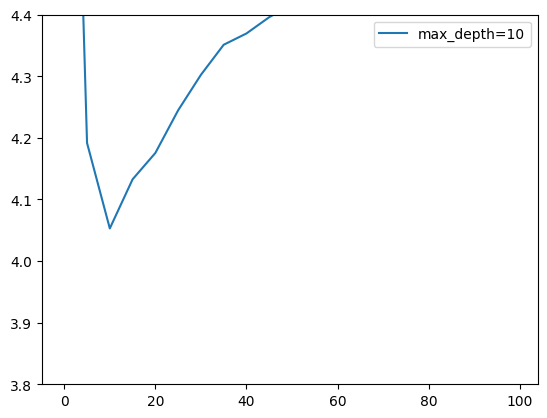

In [72]:
for max_depth, df_score in scores.items():
    
    plt.plot(df_score.num_iter, df_score.val_rmse, label=max_depth)

plt.ylim(3.8, 4.4)
plt.legend()

In [73]:
# XGBoost Params

eta=0.1
max_depth=3

In [74]:
# tuning min_child_weight

scores = {}

In [75]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 100,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=80,
                  verbose_eval=5,
                  evals=watchlist)



key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

# ['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=20', 'min_child_weight=30', 'min_child_weight=40', 'min_child_weight=100']

In [76]:
scores.keys()

dict_keys(['min_child_weight=100'])

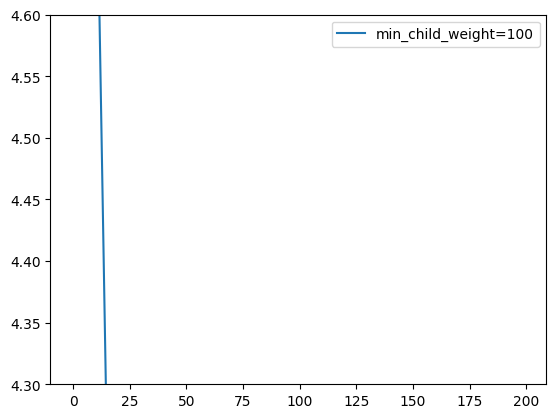

In [77]:
for min_child_weight, df_score in scores.items():
    
    plt.plot(df_score.num_iter, df_score.val_rmse, label=min_child_weight)

plt.ylim(4.3, 4.6)
plt.legend()

In [78]:
# XGBoost Params

eta=0.1
max_depth=10
min_child_weight=1

In [79]:
full_train_dicts = df_full_train.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

X_full_train = dv.fit_transform(full_train_dicts)
X_test = dv.transform(test_dicts)

dfull_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
dtest = xgb.DMatrix(X_test, feature_names=features)

In [80]:
# final model

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfull_train, num_boost_round=80)

In [81]:
y_pred = model.predict(dtest)

In [82]:
rmse(y_test, y_pred)

3.761145393348253

# Save the final XGBoost model

In [83]:
import pickle

In [84]:
output_file = f'model_eta={eta}_max_depth={max_depth}_min_child_weight={min_child_weight}.bin'
output_file

'model_eta=0.1_max_depth=10_min_child_weight=1.bin'

In [85]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

In [86]:
import pickle

In [87]:
model_file = 'model_eta=0.1_max_depth=10_min_child_weight=1.bin'

In [88]:
with open(model_file, 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [89]:
dv, model

(DictVectorizer(), <xgboost.core.Booster at 0x16de13ca0>)

In [90]:
customer = df_test.iloc[2].to_dict()
customer

{'delivery_person_age': 36.0,
 'delivery_person_ratings': 4.7,
 'weather_conditions': 'fog',
 'road_traffic_density': 'low',
 'vehicle_condition': 'unknown',
 'type_of_order': 'snack',
 'type_of_vehicle': 'motorcycle',
 'multiple_deliveries': 0.0,
 'festival': 'no',
 'city': 'metropolitian',
 'distance_km': 1.5581215151148655,
 'order_hour': 8.0,
 'order_day_of_week': 6.0,
 'preparation_time_mins': 15.0}

In [91]:
features = list(dv.get_feature_names_out())
X = dv.transform([customer])

dx = xgb.DMatrix(X, feature_names=features)

In [92]:
model.predict(dx)

array([23.753803], dtype=float32)

In [93]:
y_test[2]

25